In [51]:
# Split data
import shutil
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/val', exist_ok=True)

# Split data
IMAGES_PATH = 'images'
for category in os.listdir(IMAGES_PATH):
    if category.startswith('.'):
        continue
    os.makedirs(f'data/train/{category}', exist_ok=True)
    os.makedirs(f'data/test/{category}', exist_ok=True)
    os.makedirs(f'data/val/{category}', exist_ok=True)
    images = os.listdir(f'{IMAGES_PATH}/{category}')
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
    current_image_number = 0
    for image in train_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/train/{category}/{image_name}')
        current_image_number += 1
        
    for image in val_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/val/{category}/{image_name}')
        current_image_number += 1
        
    for image in test_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/test/{category}/{image_name}')
        current_image_number += 1
    

In [52]:
import pandas as pd
import os

data_dir = 'data'
image_paths = []
labels = []


for category in os.listdir(f'{data_dir}/train'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/train/{category}'):
        image_paths.append(f'{data_dir}/train/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

train_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/val'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/val/{category}'):
        image_paths.append(f'{data_dir}/val/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

val_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/test'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/test/{category}'):
        image_paths.append(f'{data_dir}/test/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

test_df = pd.DataFrame({'filename': image_paths, 'label': labels})




In [53]:
#Prepare data after augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range = [0.5, 1.5],
        fill_mode='nearest'
        )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')


Found 76670 validated image filenames belonging to 39 classes.
Found 32968 validated image filenames belonging to 39 classes.


In [54]:
# Description of the data
# Number of images in each category
print('Number of images in each category')
print('Train')
print(train_df['label'].value_counts())
NUM_CLASSES = len(train_df['label'].value_counts())



Number of images in each category
Train
label
_healthy                 17286
_mosaic_disease          10526
_citrus_greening          4405
_bacterial_spot           4335
_leaf_curl                4285
_late_blight              3143
_early_blight             2902
_powdery_mildew           2309
_bacterial_blight         2136
_green_mottle             1908
_black_measles            1816
_brown_streak_disease     1751
_brown_spot               1452
_black_rot                1440
_septoria_leaf_spot       1416
_rust                     1403
_spider_mites             1340
_blast                    1152
_target_spot              1123
_scab                      977
_common_rust               953
_leaf_scorch               887
_tungro                    864
_isariopsis_leaf_spot      860
_northern_leaf_blight      788
_leaf_mold                 761
_pests                     488
_bacterial_wilt            455
_virus                     425
_red_rot                   414
_gray_leaf_spot         

In [55]:
#Pre-trained model for plant leaves

from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras import layers, models, optimizers

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes=1000,
    classifier_activation="softmax",)

activation_leaky_relu = layers.LeakyReLU(alpha=0.3)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation= activation_leaky_relu)) #Set leaky relu
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))


conv_base.trainable = False
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 39)                10023     
                                                                 
Total params: 33,978,959
Trainable params: 13,117,479
Non-trainable params: 20,861,480
_________________________________________________________________


In [56]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=1e-3),
metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [57]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=val_generator,
    validation_steps=50)

/tmp/ipykernel_4112017/911059594.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
100/100 [==============================] - 25s 232ms/step - loss: 11.2788 - acc: 0.3759 - val_loss: 5.8495 - val_acc: 0.4956
Epoch 2/60
100/100 [==============================] - 23s 227ms/step - loss: 9.1121 - acc: 0.4547 - val_loss: 5.7235 - val_acc: 0.5475
Epoch 3/60
100/100 [==============================] - 23s 231ms/step - loss: 9.0079 - acc: 0.4722 - val_loss: 4.8846 - val_acc: 0.5706
Epoch 4/60
100/100 [==============================] - 23s 227ms/step - loss: 8.4802 - acc: 0.4944 - val_loss: 5.4118 - val_acc: 0.5694
Epoch 5/60
100/100 [==============================] - 23s 230ms/step - loss: 7.4686 - acc: 0.5228 - val_loss: 3.6456 - val_acc: 0.6431
Epoch 6/60
100/100 [==============================] - 23s 226ms/step - loss: 6.8910 - acc: 0.5247 - val_loss: 4.0225 - val_acc: 0.6256
Epoch 7/60
100/100 [==============================] - 22s 221ms/step - loss: 6.3601 - acc: 0.5397 - val_loss: 3.6566 - val_acc: 0.6194
Epoch 8/60
100/100 [==============================] - 

In [58]:
# # Fine-tune the model
# conv_base.trainable = True 

# model.compile(loss='categorical_crossentropy',
#                 optimizer=optimizers.Adam(lr=1e-7),
#                 metrics=['acc'])
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=50)

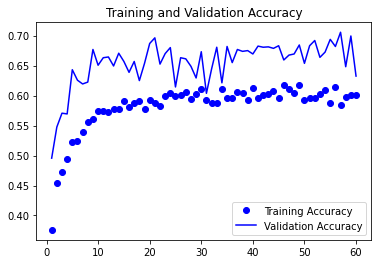

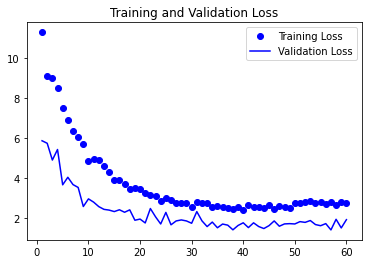

In [59]:
#Plot the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [60]:
# Test the model
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
        )

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 20356 validated image filenames belonging to 39 classes.
    1/20356 [..............................] - ETA: 34:47 - loss: 0.1232 - acc: 1.0000

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


20356/20356 [==============================] - 162s 8ms/step - loss: 2.0040 - acc: 0.6317
test acc: 0.631705641746521
test loss: 2.0040297508239746


20356/20356 [==============================] - 96s 5ms/step


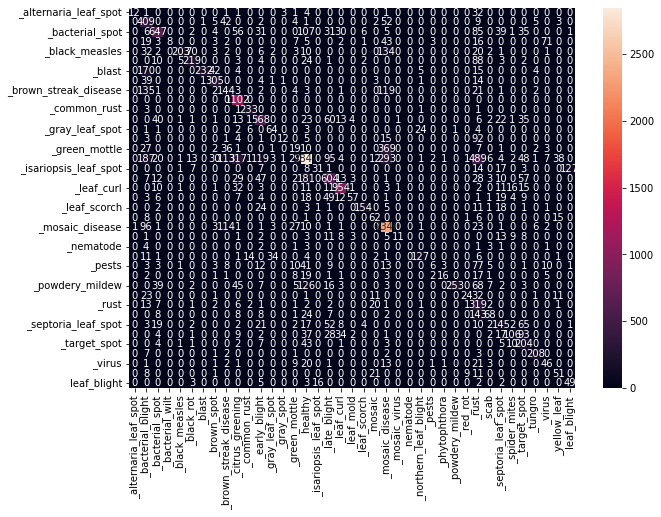

In [61]:
# Print the confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.array(test_generator.classes)

confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, index = [i for i in test_generator.class_indices],
                  columns = [i for i in test_generator.class_indices])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()


In [62]:
# Display precision, recall, and F1-score of each class
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



                       precision    recall  f1-score   support

_alternaria_leaf_spot       0.92      0.21      0.35        56
    _bacterial_blight       0.33      0.76      0.47       535
      _bacterial_spot       0.77      0.60      0.67      1086
      _bacterial_wilt       1.00      0.04      0.08       183
       _black_measles       0.95      0.41      0.58       491
           _black_rot       0.68      0.61      0.64       361
               _blast       0.99      0.49      0.66       472
          _brown_spot       0.74      0.83      0.78       369
_brown_streak_disease       0.31      0.33      0.32       438
     _citrus_greening       0.67      1.00      0.80      1102
         _common_rust       0.91      0.97      0.94       239
        _early_blight       0.64      0.72      0.68       792
      _gray_leaf_spot       0.59      0.60      0.60       106
           _gray_spot       0.71      0.09      0.16       133
        _green_mottle       0.14      0.04      0.06  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
